## <center> Capstone Project 1</center> ##
### <center> Vikram Lucky


### Data Wrangling

# [ Airbnb New User Bookings:](https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings)

### <font color =red>Problem Question: Where will new guest book their first trip?</font>
#### *“New users on Airbnb can book a place to stay in 34,000+ cities across 190+ countries. By accurately predicting where a new user will book their first travel experience, Airbnb can share more personalized content with their community, decrease the average time to first booking, and better forecast demand.”-Airbnb-Kaggle* ####
### Type: Multiclass Classification Problem
### Source: Kaggle Competition
### Data: Contains 4 .csv files + 1.csv for test set which will not be used for this project

In [2]:
import pandas as pd
import seaborn as sns
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_columns', None)
%matplotlib inline
sns.set(style="darkgrid")

In [3]:
df = pd.read_csv('/Users/lucky/Large_Project_Files/Airbnb/train_users_2.csv')
countries = pd.read_csv('./countries.csv')
sessions = pd.read_csv('/Users/lucky/Large_Project_Files/Airbnb//sessions.csv')
age_gender_bkts = pd.read_csv('./age_gender_bkts.csv')

#### Data Wrangling - Training data

In [4]:
print("Shape of Traning dataset: ", df.shape)
df.head(2)

Shape of Traning dataset:  (213451, 16)


,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF


In [5]:
df.describe()

,timestamp_first_active,age,signup_flow
count,2.134510e+05,125461.000000,213451.000000
mean,2.013085e+13,49.668335,3.267387
std,9.253717e+09,155.666612,7.637707
min,2.009032e+13,1.000000,0.000000
25%,2.012123e+13,28.000000,0.000000
50%,2.013091e+13,34.000000,0.000000
75%,2.014031e+13,43.000000,0.000000
max,2.014063e+13,2014.000000,25.000000


Description of traning data, we already see some irregular values for example max age = 2014 as well as many missing values in age column. Lets check total number of missing value in our traininig data. As we have only 16 columns, I think it's better to inspect them one by one.

Before we impute missing values, we will convert df['Date_Account_Created', 'timestamp_first_active'] columns to datetime object columns.

In [6]:
df['date_account_created'] =  pd.to_datetime(df['date_account_created'], format='%Y-%m-%d')
df['timestamp_first_active'] =  pd.to_datetime(df['timestamp_first_active'], format='%Y%m%d%H%M%S')

In [7]:
df.head(2)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF


The first column with missing values we have is date_first_booking. Let's inspect it.

In [8]:
df.date_first_booking.value_counts(dropna=False).head()/len(df)

NaN           0.583473
2014-05-22    0.001162
2014-06-11    0.001082
2014-06-24    0.001059
2014-05-21    0.001054
Name: date_first_booking, dtype: float64

In [9]:
df.country_destination.value_counts(dropna= False).head()/len(df)

NDF      0.583473
US       0.292226
other    0.047290
FR       0.023532
IT       0.013282
Name: country_destination, dtype: float64

58% of the data in date_first_booking column is missing, Date first booking columns contains the date of users first booked their trip. As shown above date_first_booking contains np.nan values for user who never booked any trips. As % of NaN values in date_first_booking is same as NDF in country destination. We will leave this column as it is for now, If imputed this column might leak information.

In [10]:
print(df['age'].value_counts(dropna= False).head()/len(df))
print(df['gender'].value_counts(dropna= False).head()/len(df))

NaN      0.412226
 30.0    0.028690
 31.0    0.028184
 29.0    0.027936
 28.0    0.027824
Name: age, dtype: float64
-unknown-    0.448290
FEMALE       0.295342
MALE         0.255047
OTHER        0.001321
Name: gender, dtype: float64


Age and Gender columns have some missing values, I think these columns are very robust we will have to fill up these NaN values with some sensible data.


### Age Column

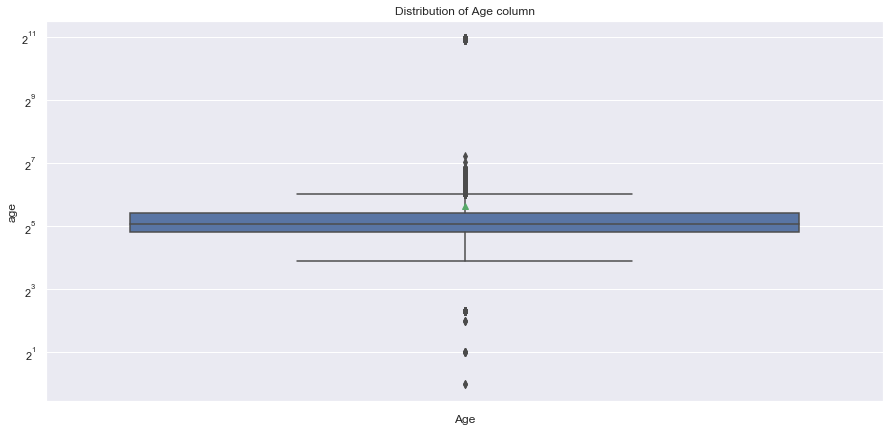

In [11]:
plt.figure(figsize=(15,7))
sns.boxplot(x = 'age', data =df, orient = "v", showmeans = True)
plt.yscale('log',basey=2)
plt.title('Distribution of Age column')
plt.xlabel('Age')
plt.savefig('boxplot')

Age column needs some work, So many irregular values. Values below 18 (accoring to Airbnb policy you have to be at least 18 years old to book a trip), where max age is not specified, so i am going to assume 90 as max value

In [12]:
print("Ages above 90 in age columns ", df[df['age'] > 90].age.value_counts(dropna=True).sum())
print("Ages Below 18 in age columns ", df[df['age']<18].age.value_counts(dropna= True).sum())

Ages above 90 in age columns  2543
Ages Below 18 in age columns  158


In [13]:
# Below we will replace value above 90 and below 18 with np.nan, and then np.nan with mean values
df.loc[df['age'] > 90, 'age'] = np.nan
df.loc[df['age'] < 18, 'age'] = np.nan
df.age.value_counts(dropna =False).head()/len(df)

NaN      0.424880
 30.0    0.028690
 31.0    0.028184
 29.0    0.027936
 28.0    0.027824
Name: age, dtype: float64

In [14]:
mean_age = np.mean(df['age'])
print("Mean age ",mean_age)
df['age'] = df['age'].fillna(mean_age)

Mean age  36.480164548712935


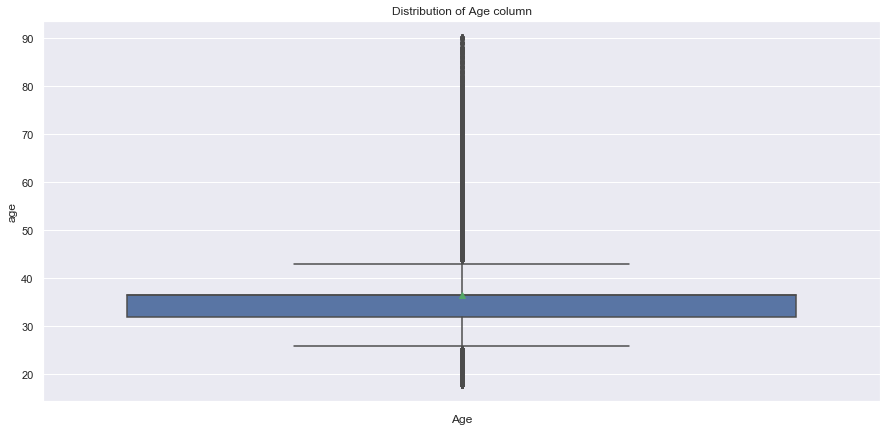

In [15]:
plt.figure(figsize=(15,7))
sns.boxplot(x = 'age', data =df, orient = "v", showmeans = True)
plt.title('Distribution of Age column')
plt.xlabel('Age')
plt.savefig('boxplot')

In [16]:
df.age = df.age.astype(int)
df.age.value_counts(dropna =False).head()/len(df)

36    0.444008
30    0.028690
31    0.028184
29    0.027936
28    0.027824
Name: age, dtype: float64

### Gender column

In [17]:
import matplotlib.pyplot as plt

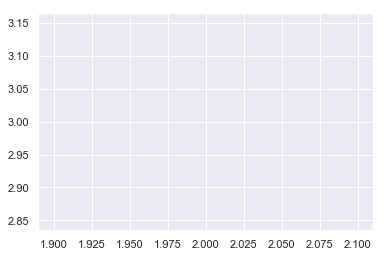

In [18]:
x =2 
y =3
plt.plot(x,y)

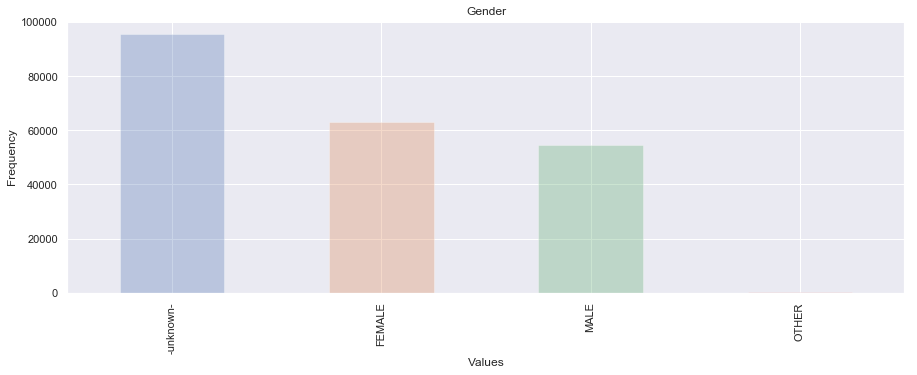

In [19]:
df.gender.value_counts(dropna=False).plot(kind='bar',alpha=.30, figsize = (15, 5));
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Gender');

In [20]:
def recode_sex(sex_value):
    if sex_value == 'MALE':
        return 'M'
    elif sex_value == 'FEMALE':
        return 'F'
    else:
        return "Unknw"
df['gender'] = df.gender.apply(recode_sex)    

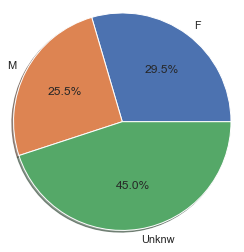

In [21]:
labels = df['gender'].astype('category').cat.categories.tolist()
counts = df['gender'].value_counts()
sizes = [counts[var_cat] for var_cat in labels]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, radius=1.25) 
plt.show()

In [22]:
df.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,NaN,Unknw,36,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,NaN,M,38,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,F,56,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,F,42,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,2010-02-18,Unknw,41,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


### Signup Method


In [23]:
df.signup_method.value_counts(dropna=False)

basic       152897
facebook     60008
google         546
Name: signup_method, dtype: int64

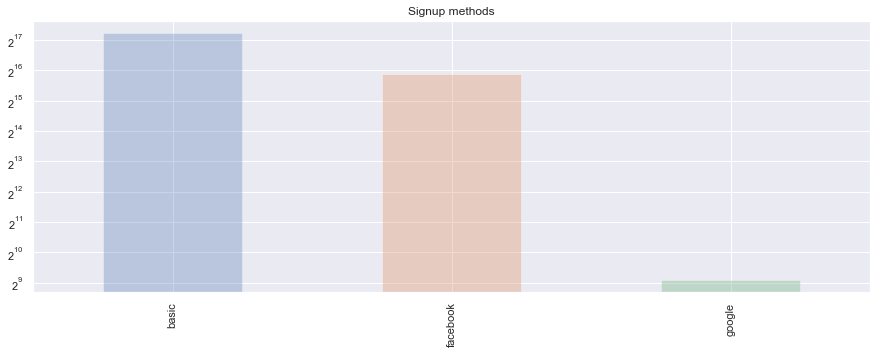

In [24]:
df.signup_method.value_counts(dropna=False).plot(kind = "bar",alpha=.30, figsize = (15, 5))
plt.yscale('log',basey=2)
plt.title('Signup methods');

df['signup_method'] column looks good as it is, as there are no missing values. However later in the feature engineering part we will encode the categorical into suitable numeric values.

### Signup_Flow 

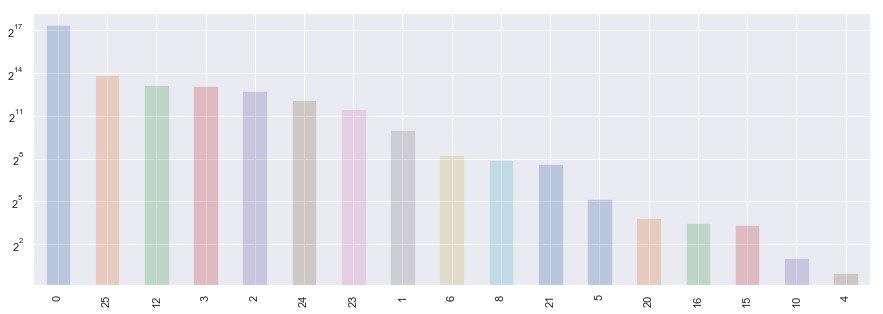

In [25]:
df.signup_flow.value_counts(dropna = False).plot(kind = "bar",alpha=.30, figsize = (15, 5))
plt.yscale('log',basey=2)

df.singup_flow contains information about the page a user came to signup up from. We will leave this as it is for now.

### Language

In [26]:
df.language.value_counts(dropna = False)

en    206314
zh      1632
fr      1172
es       915
ko       747
de       732
it       514
ru       389
pt       240
ja       225
sv       122
nl        97
tr        64
da        58
pl        54
cs        32
no        30
el        24
th        24
id        22
hu        18
fi        14
ca         5
is         5
hr         2
Name: language, dtype: int64

The Language column contains language codes, I am not familiar with some of the codes. So, i will find .csv file containing codes with respective language and will covert these codes to full language names for now.

In [27]:
language_codes = pd.read_csv('./language_codes.csv')
#This file from https://datahub.io/core/language-codes#resource-language-codes

In [28]:
language_codes.head(2)

,alpha2,English
0,aa,Afar
1,ab,Abkhazian


In [29]:
keys = language_codes['alpha2'].tolist()
values = language_codes['English'].tolist()
language_code = dict(zip(keys, values))

In [30]:
def lang_func(code):
    return language_code[code]

In [31]:
df['language'] = df.language.apply(lang_func)    

In [32]:
df['language'].value_counts()

English                  206314
Chinese                    1632
French                     1172
Spanish; Castilian          915
Korean                      747
German                      732
Italian                     514
Russian                     389
Portuguese                  240
Japanese                    225
Swedish                     122
Dutch; Flemish               97
Turkish                      64
Danish                       58
Polish                       54
Czech                        32
Norwegian                    30
Greek, Modern (1453-)        24
Thai                         24
Indonesian                   22
Hungarian                    18
Finnish                      14
Icelandic                     5
Catalan; Valencian            5
Croatian                      2
Name: language, dtype: int64

Much betterm to read!

### Affiliate channel <br>
what kind of paid marketing

In [33]:
df.affiliate_channel.value_counts(dropna = False)

direct           137727
sem-brand         26045
sem-non-brand     18844
other              8961
seo                8663
api                8167
content            3948
remarketing        1096
Name: affiliate_channel, dtype: int64

### Affiliate Provider<br>
where the marketing is e.g. google, craigslist, other

In [34]:
df.affiliate_provider.value_counts(dropna= False)

direct                 137426
google                  51693
other                   12549
craigslist               3471
bing                     2328
facebook                 2273
vast                      829
padmapper                 768
facebook-open-graph       545
yahoo                     496
gsp                       453
meetup                    347
email-marketing           166
naver                      52
baidu                      29
yandex                     17
wayn                        8
daum                        1
Name: affiliate_provider, dtype: int64

### First Affiliate Tracked <br>
whats the first marketing the user interacted with before the signing up

In [35]:
df.first_affiliate_tracked.value_counts(dropna = False)/len(df)

untracked        0.511743
linked           0.216851
omg              0.206052
tracked-other    0.028840
NaN              0.028414
product          0.007290
marketing        0.000651
local ops        0.000159
Name: first_affiliate_tracked, dtype: float64

In [36]:
# About ~3% of the data is missing, for now we will just replace it with 'Unknown'

In [37]:
df['first_affiliate_tracked'] = df['first_affiliate_tracked'].fillna('Unknown')

In [38]:
df.first_affiliate_tracked.value_counts(dropna = False)/len(df)

untracked        0.511743
linked           0.216851
omg              0.206052
tracked-other    0.028840
Unknown          0.028414
product          0.007290
marketing        0.000651
local ops        0.000159
Name: first_affiliate_tracked, dtype: float64

### signup_app

In [39]:
df.signup_app.value_counts(dropna =False)/len(df)

Web        0.856014
iOS        0.089102
Moweb      0.029332
Android    0.025552
Name: signup_app, dtype: float64

### Frist device type

In [40]:
df.first_device_type.value_counts(dropna =False)

Mac Desktop           89600
Windows Desktop       72716
iPhone                20759
iPad                  14339
Other/Unknown         10667
Android Phone          2803
Android Tablet         1292
Desktop (Other)        1199
SmartPhone (Other)       76
Name: first_device_type, dtype: int64

###  First Browser

In [41]:
print(df.first_browser.isnull().any())
print(df.first_browser.value_counts(dropna=False).head(5))

False
Chrome       63845
Safari       45169
Firefox      33655
-unknown-    27266
IE           21068
Name: first_browser, dtype: int64


### Country Destination - This is our target variable

In [42]:
df.country_destination.value_counts()

NDF      124543
US        62376
other     10094
FR         5023
IT         2835
GB         2324
ES         2249
CA         1428
DE         1061
NL          762
AU          539
PT          217
Name: country_destination, dtype: int64

There are 12 possible outcomes of the destination country: 'US', 'FR', 'CA', 'GB', 'ES', 'IT', 'PT', 'NL','DE', 'AU', 'NDF' (no destination found), and 'other'. Please note that 'NDF' is different from 'other' because 'other' means there was a booking, but is to a country not included in the list, while 'NDF' means there wasn't a booking.

In [43]:
df.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,NaN,Unknw,36,facebook,0,English,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,NaN,M,38,facebook,0,English,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,F,56,basic,3,English,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,F,42,facebook,0,English,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,2010-02-18,Unknw,41,basic,0,English,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [44]:
df.isnull().any().sum()

1

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
id                         213451 non-null object
date_account_created       213451 non-null datetime64[ns]
timestamp_first_active     213451 non-null datetime64[ns]
date_first_booking         88908 non-null object
gender                     213451 non-null object
age                        213451 non-null int64
signup_method              213451 non-null object
signup_flow                213451 non-null int64
language                   213451 non-null object
affiliate_channel          213451 non-null object
affiliate_provider         213451 non-null object
first_affiliate_tracked    213451 non-null object
signup_app                 213451 non-null object
first_device_type          213451 non-null object
first_browser              213451 non-null object
country_destination        213451 non-null object
dtypes: datetime64[ns](2), int64(2), object(12)
memory usage: 26.1+ MB


In [46]:
df.shape

(213451, 16)

Our main train.csv df looks good, each columns is in expected dtype. And no missing values. lets explore other .csv files

### Sessions.csv  contains  information about web sessions log for users
##### user_id to be joined with used_id in traning df. 

In [47]:
sessions.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


In [48]:
sessions.action_detail.value_counts(dropna = False)[:5]

view_search_results        1776885
p3                         1376550
NaN                        1126204
-unknown-                  1031141
wishlist_content_update     706824
Name: action_detail, dtype: int64

In [49]:
sessions['action_detail'] = sessions.action_detail.apply(lambda x: np.nan if x == '-unknown-' else x)

In [50]:
sessions.action_detail.value_counts(dropna = False)[:5]

NaN                        2157345
view_search_results        1776885
p3                         1376550
wishlist_content_update     706824
user_profile                656839
Name: action_detail, dtype: int64

In [51]:
sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10567737 entries, 0 to 10567736
Data columns (total 6 columns):
user_id          object
action           object
action_type      object
action_detail    object
device_type      object
secs_elapsed     float64
dtypes: float64(1), object(5)
memory usage: 483.8+ MB


In [52]:
sessions.isnull().any()

user_id           True
action            True
action_type       True
action_detail     True
device_type      False
secs_elapsed      True
dtype: bool

In [53]:
#We see some missing values in user_id, we are going to drop rows where user_id is np.NaN
sessions.dropna(subset=['user_id'], inplace =True)

In [54]:
sessions.shape

(10533241, 6)

About 34496 rows contained missing user_id and all have been removed.

In [55]:
sessions.isnull().any()

user_id          False
action            True
action_type       True
action_detail     True
device_type      False
secs_elapsed      True
dtype: bool

As this is not our Traning dataset, we will leave this out for now until we get to ML part, if required we might extract some information from sessions dataframe. But for now we will exclude it.

### Age gender bucket

In [56]:
age_gender_bkts.head()

,age_bucket,country_destination,gender,population_in_thousands,year
0,100+,AU,male,1.0,2015.0
1,95-99,AU,male,9.0,2015.0
2,90-94,AU,male,47.0,2015.0
3,85-89,AU,male,118.0,2015.0
4,80-84,AU,male,199.0,2015.0


In [57]:
age_gender_bkts.isnull().any()

age_bucket                 False
country_destination        False
gender                     False
population_in_thousands    False
year                       False
dtype: bool

In [58]:
age_gender_bkts.shape

(420, 5)

### Countries

In [59]:
countries.shape

(10, 7)

In [60]:
countries.head()

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220.0,eng,0.00
1,CA,62.393303,-96.818146,2828.1333,9984670.0,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022.0,deu,72.61
3,ES,39.896027,-2.487694,7730.7240,505370.0,spa,92.25
4,FR,46.232193,2.209667,7682.9450,643801.0,fra,92.06


In [61]:
countries.isnull().any()

country_destination              False
lat_destination                  False
lng_destination                  False
distance_km                      False
destination_km2                  False
destination_language             False
language_levenshtein_distance    False
dtype: bool

This concludes the data wrangling part. As all of the columns are in right dtype format, we have idientified and replaced outliers with sensibile values, and imputed the missing values except from session.csv.

In [62]:
df.to_csv('df_datawrangling.csv')

In [ ]:
y_sm.dtype

dtype('int64')

In [ ]:
a = list(y_sm)
b = {}
for each in a:
    if each not in b.keys():
        b[each] = 1
    else:
        b[each] += 1
#just checking the proporation of each class in our data

In [ ]:
b #All of the classes are balanced now

{10: 43677,
 0: 43677,
 8: 43677,
 5: 43677,
 4: 43677,
 7: 43677,
 3: 43677,
 6: 43677,
 2: 43677,
 1: 43677,
 9: 43677}

In [ ]:
y_test = y_test.astype(np.int64)

In [ ]:
Cs = [0.1, 1, 10]
for each in Cs:
    lg = LogisticRegression(penalty = 'l2', C = each)
    lg.fit(X_sm, y_sm)
    y_pred = lg.predict(X_test)
    print("Accuracy score w/ C: ", each,accuracy_score(y_pred, y_test))
    print("Classification Report C: ",each)
    print(classification_report(y_test, y_pred))
    print("--------------------------------------------------------------------")

Accuracy score w/ C:  0.1 0.1037378622577138
Classification Report C:  0.1
             precision    recall  f1-score   support

          0       0.78      0.11      0.20     18699
          1       0.01      0.19      0.02       154
          2       0.02      0.11      0.03       431
          3       0.02      0.11      0.03       327
          4       0.03      0.05      0.04       683
          5       0.10      0.08      0.08      1533
          6       0.04      0.10      0.06       695
          7       0.05      0.08      0.06       843
          8       0.01      0.10      0.02       243
          9       0.00      0.28      0.01        64
         10       0.15      0.07      0.09      3001

avg / total       0.58      0.10      0.16     26673

--------------------------------------------------------------------


SMOTE did not perfom well. Let's try Undersampling technique

In [97]:
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler, NearMiss, CondensedNearestNeighbour, TomekLinks

In [98]:
us = RandomUnderSampler(ratio = 0.5, random_state = 1)
X_train_res, y_train_res = us.fit_sample(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [99]:
print("Distribution of class labels before resampling ", Counter(y_train))
print("Distribution of class labels after resampling ", Counter(y_train_res))

Distribution of class labels before resampling  Counter({'NDF': 87180, 'US': 43663, 'other': 7066, 'FR': 3516, 'IT': 1984, 'GB': 1627, 'ES': 1574, 'CA': 1000, 'DE': 743, 'NL': 533, 'AU': 377, 'PT': 152})
Distribution of class labels after resampling  Counter({'AU': 304, 'CA': 304, 'DE': 304, 'ES': 304, 'FR': 304, 'GB': 304, 'IT': 304, 'NDF': 304, 'NL': 304, 'US': 304, 'other': 304, 'PT': 152})


In [100]:
clf_base = LogisticRegression()
grid = {'C': [0.001, .1, 1, 10],'penalty': ['l1', 'l2']}
cv = KFold(n_splits = 5, shuffle = True, random_state = 0)
clf = GridSearchCV(clf_base, grid, cv = cv, n_jobs = 8, scoring = 'f1_macro')

clf.fit(X_train_res, y_train_res)
coef = clf.best_estimator_.coef_
intercept = clf.best_estimator_.intercept_

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:113

In [103]:
clf.best_estimator_

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [104]:
clf.best_score_

0.10520025222438437

Undersampling technique performed worse than oversampling.Now, lets convert this multiclass classification problem to binary classification by having just two classes users traveling within US vs user traveling outside US.

In [106]:
train.head()

,country_destination,gender_M,gender_Unknw,age_19,age_20,age_21,age_22,age_23,age_24,age_25,age_26,age_27,age_28,age_29,age_30,age_31,age_32,age_33,age_34,age_35,age_36,age_37,age_38,age_39,age_40,age_41,age_42,age_43,age_44,age_45,age_46,age_47,age_48,age_49,age_50,age_51,age_52,age_53,age_54,age_55,age_56,age_57,age_58,age_59,age_60,age_61,age_62,age_63,age_64,age_65,age_66,age_67,age_68,age_69,age_70,age_71,age_72,age_73,age_74,age_75,age_76,age_77,age_78,age_79,age_80,age_81,age_82,age_83,age_84,age_85,age_86,age_87,age_88,age_89,age_90,signup_method_facebook,signup_method_google,language_Chinese,language_Croatian,language_Czech,language_Danish,language_Dutch; Flemish,language_English,language_Finnish,language_French,language_German,"language_Greek, Modern (1453-)",language_Hungarian,language_Icelandic,language_Indonesian,language_Italian,language_Japanese,language_Korean,language_Norwegian,language_Polish,language_Portuguese,language_Russian,language_Spanish; Castilian,language_Swedish,language_Thai,language_Turkish,affiliate_channel_content,affiliate_channel_direct,affiliate_channel_other,affiliate_channel_remarketing,affiliate_channel_sem-brand,affiliate_channel_sem-non-brand,affiliate_channel_seo,affiliate_provider_bing,affiliate_provider_craigslist,affiliate_provider_daum,affiliate_provider_direct,affiliate_provider_email-marketing,affiliate_provider_facebook,affiliate_provider_facebook-open-graph,affiliate_provider_google,affiliate_provider_gsp,affiliate_provider_meetup,affiliate_provider_naver,affiliate_provider_other,affiliate_provider_padmapper,affiliate_provider_vast,affiliate_provider_wayn,affiliate_provider_yahoo,affiliate_provider_yandex,first_affiliate_tracked_linked,first_affiliate_tracked_local ops,first_affiliate_tracked_marketing,first_affiliate_tracked_omg,first_affiliate_tracked_product,first_affiliate_tracked_tracked-other,first_affiliate_tracked_untracked,signup_app_Moweb,signup_app_Web,signup_app_iOS,first_device_type_Android Tablet,first_device_type_Desktop (Other),first_device_type_Mac Desktop,first_device_type_Other/Unknown,first_device_type_SmartPhone (Other),first_device_type_Windows Desktop,first_device_type_iPad,first_device_type_iPhone,first_browser_AOL Explorer,first_browser_Android Browser,first_browser_Apple Mail,first_browser_Arora,first_browser_Avant Browser,first_browser_BlackBerry Browser,first_browser_Camino,first_browser_Chrome,first_browser_Chrome Mobile,first_browser_Chromium,first_browser_CometBird,first_browser_Comodo Dragon,first_browser_Conkeror,first_browser_CoolNovo,first_browser_Crazy Browser,first_browser_Epic,first_browser_Firefox,first_browser_Flock,first_browser_Google Earth,first_browser_Googlebot,first_browser_IE,first_browser_IE Mobile,first_browser_IceDragon,first_browser_IceWeasel,first_browser_Iron,first_browser_Kindle Browser,first_browser_Maxthon,first_browser_Mobile Firefox,first_browser_Mobile Safari,first_browser_Mozilla,first_browser_NetNewsWire,first_browser_OmniWeb,first_browser_Opera,first_browser_Opera Mini,first_browser_Opera Mobile,first_browser_Outlook 2007,first_browser_PS Vita browser,first_browser_Pale Moon,first_browser_Palm Pre web browser,first_browser_RockMelt,first_browser_Safari,first_browser_SeaMonkey,first_browser_Silk,first_browser_SiteKiosk,first_browser_SlimBrowser,first_browser_Sogou Explorer,first_browser_Stainless,first_browser_TenFourFox,first_browser_TheWorld Browser,first_browser_Yandex.Browser,first_browser_wOSBrowser
0,NDF,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,NDF,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [107]:
train.shape

(213451, 194)

In [108]:
train.country_destination.value_counts()

NDF      124543
US        62376
other     10094
FR         5023
IT         2835
GB         2324
ES         2249
CA         1428
DE         1061
NL          762
AU          539
PT          217
Name: country_destination, dtype: int64

In [94]:
df = train.copy() #making copy of original data

In [95]:
df = df[df['country_destination'] != 'NDF']

df.shape

df['country_destination'] = df.country_destination.apply(lambda x: 1 if x == 'US' else 0)

print(df.country_destination.value_counts())
df.head()

### 1: users traveling within US <br> 0: User travel outside US <br>Can we build a model that accurately predict if user will book locally or outside US

In [99]:
sum(df.country_destination)/(float(len(df.country_destination))) #Baseline

0.7015791604804967

We converted multilcass classfication problem to Binary classfication, but we still have class imbalanced problem which we will tackle the similar way we did above.

In [100]:
X = df.drop(['country_destination'], axis = 1 )
y = df.country_destination
ss = StandardScaler()
Xs = pd.DataFrame(ss.fit_transform(X, y), columns = X.columns)

Logistic Regression + Cross Validation



In [141]:
lr = LogisticRegression()
scores = cross_val_score(lr, Xs, y, cv=5)
scores

array([0.69920711, 0.70053987, 0.70114167, 0.70142287, 0.70052303])

In [142]:
print("Random Forest Classifier + crossvalidation")

cv = StratifiedKFold(n_splits=10, random_state=21, shuffle=True)
rf = RandomForestClassifier()
cross_val_score(rf, Xs, y, cv=cv)

Random Forest Classifier + crossvalidation


array([0.66475484, 0.66250562, 0.65965583, 0.66899111, 0.66460466,
       0.66111798, 0.65714286, 0.66152981, 0.6640045 , 0.67210349])

Logistic Regression and RandomForest classfier both performed below our baseline which is .70

## SMOTE 

In [102]:
from imblearn.over_sampling import SMOTE
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(Xs, y, random_state=42, test_size=0.3)
smote = SMOTE(random_state=12, ratio = 1.0, )
X_sm, y_sm = smote.fit_sample(X_train, y_train)

rf = RandomForestClassifier(oob_score= True)
rf.fit(X_sm, y_sm)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [128]:
predictions = rf.predict(X_test)
yhat_pp = rf.predict_proba(X_test)

print("Accuracy Score: ",metrics.accuracy_score(y_test, predictions))

Accuracy Score:  0.5649158324897837


In [129]:
print('\nTest Results')
print(rf.score(X_test, y_test))
print(metrics.recall_score(y_test, rf.predict(X_test)))


Test Results
0.5649158324897837
0.6357024439809615


In [130]:
conmat = np.array(metrics.confusion_matrix(y_test, predictions, labels=[1,0]))

confusion = pd.DataFrame(conmat, index=['US', 'Outside US'],
                         columns=['predicted_US','predicted_OUTSIDE_US'])
confusion

,predicted_US,predicted_OUTSIDE_US
US,11887,6812
Outside US,4793,3181


We will have to choose a different approach to deal with this problem. <br> Let's try Random Forest with Grid Search. <br>
### Finding best number of estimators



/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=

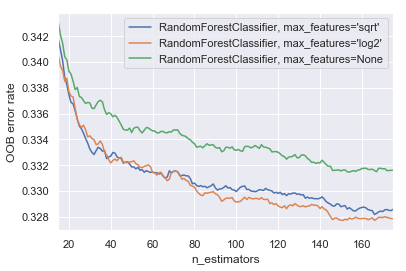

In [156]:
from collections import OrderedDict
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
RANDOM_STATE = 143
# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.
ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(n_estimators=100,
                               warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(n_estimators=100,
                               warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(n_estimators=100,
                               warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]
# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 15
max_estimators = 175

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(Xs, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

In [103]:
from sklearn.model_selection import GridSearchCV
#scores = ['accuracy', 'f1', 'precision', 'recall']


params = {'n_estimators':[144, 170, 194],
           'criterion': ['gini', 'entropy'],
           'max_depth': [None, 3, 5, 10],
           'min_samples_split': [2, 5, 10],
           'class_weight':[None, 'balanced'],
           'max_features' : ['log2']}


gsrf = GridSearchCV(RandomForestClassifier(n_jobs=-1, oob_score = True),
                     params, n_jobs=-1, 
                    #scoring = scores,
                    cv=KFold(n_splits=3, shuffle=True),
                    refit = 'oob_score')

gsrf.fit(X_sm, y_sm)
print(gsrf.best_params_)
print(gsrf.best_score_)

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 194}
0.661068754722165


use above hypermeters.

Trying Undersampling technique for binary classification:

In [104]:
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

X = df.drop(['country_destination'], axis = 1 )
y = df.country_destination
ss = StandardScaler()
Xs = pd.DataFrame(ss.fit_transform(X, y), columns = X.columns)
X_train, X_test, y_train, y_test = train_test_split(Xs, y, random_state=42, test_size=0.3)

us = RandomUnderSampler(ratio = 1, random_state = 1)
X_train_res, y_train_res = us.fit_sample(X_train, y_train)

Counter(y_train_res)
print("Distribution of class labels before resampling ", Counter(y_train))
print("Distribution of class labels after resampling ", Counter(y_train_res))

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


Distribution of class labels before resampling  Counter({1: 43677, 0: 18558})
Distribution of class labels after resampling  Counter({0: 18558, 1: 18558})


In [105]:
from sklearn.model_selection import GridSearchCV


params = {'n_estimators':[100, 140, 170, 194],
           'criterion': ['gini', 'entropy'],
           'max_depth': [None, 3, 5, 10],
           'min_samples_split': [2,5, 10],
           'class_weight':[None, 'balanced'],
         'max_features' : ['log2']}


gsrf = GridSearchCV(RandomForestClassifier(n_jobs=-1, oob_score = True),
                     params, n_jobs=-1,
                    refit = 'oob_score',
                    cv=KFold(n_splits=3, shuffle=True))

gsrf.fit(X_train_res, y_train_res)
print(gsrf.best_params_)
print(gsrf.best_score_)

{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_split': 5, 'n_estimators': 140}
0.5391744800086217


In [106]:
X = df.drop(['country_destination'], axis = 1 )
y = df.country_destination
ss = StandardScaler()
Xs = pd.DataFrame(ss.fit_transform(X, y), columns = X.columns)
#X_train, X_test, y_train, y_test = train_test_split(Xs, y, random_state=42, test_size=0.3)

us = RandomUnderSampler(ratio = 1, random_state = 1)
Xs_res, ys_res = us.fit_sample(Xs, y)

print("Distribution of class labels before resampling ", Counter(y))
print("Distribution of class labels after resampling ", Counter(ys_res))

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


Distribution of class labels before resampling  Counter({1: 62376, 0: 26532})
Distribution of class labels after resampling  Counter({0: 26532, 1: 26532})


In [107]:
#X_train, X_test, y_train, y_test = train_test_split(Xs_res, ys_res, random_state=42, test_size=0.3)

In [108]:
params = {'n_estimators':[100, 140, 194],
           'criterion': ['gini', 'entropy'],
           'max_depth': [None, 5, 10, 15],
           'min_samples_split': [2,5],
           'class_weight':[None, 'balanced']}


gsrf = GridSearchCV(RandomForestClassifier(n_jobs=-1, oob_score = True),
                     params, n_jobs=-1,
                    cv=KFold(n_splits=3, shuffle=True),
                   refit= 'oob_score')

gsrf.fit(Xs_res, ys_res)
print(gsrf.best_params_)
print(gsrf.best_score_)

{'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 140}
0.5394429368309965


In [ ]:
#Do grid sesarch again ob score
#Support vector machine 

In [94]:
from xgboost import XGBClassifier

In [95]:
df = train.copy()
df = df[df['country_destination'] != 'NDF']

df.shape

df['country_destination'] = df.country_destination.apply(lambda x: 0 if x == 'US' else 1)

print(df.country_destination.value_counts())
df.head()

0    62376
1    26532
Name: country_destination, dtype: int64


,country_destination,gender_M,gender_Unknw,age_19,age_20,age_21,age_22,age_23,age_24,age_25,age_26,age_27,age_28,age_29,age_30,age_31,age_32,age_33,age_34,age_35,age_36,age_37,age_38,age_39,age_40,age_41,age_42,age_43,age_44,age_45,age_46,age_47,age_48,age_49,age_50,age_51,age_52,age_53,age_54,age_55,age_56,age_57,age_58,age_59,age_60,age_61,age_62,age_63,age_64,age_65,age_66,age_67,age_68,age_69,age_70,age_71,age_72,age_73,age_74,age_75,age_76,age_77,age_78,age_79,age_80,age_81,age_82,age_83,age_84,age_85,age_86,age_87,age_88,age_89,age_90,signup_method_facebook,signup_method_google,language_Chinese,language_Croatian,language_Czech,language_Danish,language_Dutch; Flemish,language_English,language_Finnish,language_French,language_German,"language_Greek, Modern (1453-)",language_Hungarian,language_Icelandic,language_Indonesian,language_Italian,language_Japanese,language_Korean,language_Norwegian,language_Polish,language_Portuguese,language_Russian,language_Spanish; Castilian,language_Swedish,language_Thai,language_Turkish,affiliate_channel_content,affiliate_channel_direct,affiliate_channel_other,affiliate_channel_remarketing,affiliate_channel_sem-brand,affiliate_channel_sem-non-brand,affiliate_channel_seo,affiliate_provider_bing,affiliate_provider_craigslist,affiliate_provider_daum,affiliate_provider_direct,affiliate_provider_email-marketing,affiliate_provider_facebook,affiliate_provider_facebook-open-graph,affiliate_provider_google,affiliate_provider_gsp,affiliate_provider_meetup,affiliate_provider_naver,affiliate_provider_other,affiliate_provider_padmapper,affiliate_provider_vast,affiliate_provider_wayn,affiliate_provider_yahoo,affiliate_provider_yandex,first_affiliate_tracked_linked,first_affiliate_tracked_local ops,first_affiliate_tracked_marketing,first_affiliate_tracked_omg,first_affiliate_tracked_product,first_affiliate_tracked_tracked-other,first_affiliate_tracked_untracked,signup_app_Moweb,signup_app_Web,signup_app_iOS,first_device_type_Android Tablet,first_device_type_Desktop (Other),first_device_type_Mac Desktop,first_device_type_Other/Unknown,first_device_type_SmartPhone (Other),first_device_type_Windows Desktop,first_device_type_iPad,first_device_type_iPhone,first_browser_AOL Explorer,first_browser_Android Browser,first_browser_Apple Mail,first_browser_Arora,first_browser_Avant Browser,first_browser_BlackBerry Browser,first_browser_Camino,first_browser_Chrome,first_browser_Chrome Mobile,first_browser_Chromium,first_browser_CometBird,first_browser_Comodo Dragon,first_browser_Conkeror,first_browser_CoolNovo,first_browser_Crazy Browser,first_browser_Epic,first_browser_Firefox,first_browser_Flock,first_browser_Google Earth,first_browser_Googlebot,first_browser_IE,first_browser_IE Mobile,first_browser_IceDragon,first_browser_IceWeasel,first_browser_Iron,first_browser_Kindle Browser,first_browser_Maxthon,first_browser_Mobile Firefox,first_browser_Mobile Safari,first_browser_Mozilla,first_browser_NetNewsWire,first_browser_OmniWeb,first_browser_Opera,first_browser_Opera Mini,first_browser_Opera Mobile,first_browser_Outlook 2007,first_browser_PS Vita browser,first_browser_Pale Moon,first_browser_Palm Pre web browser,first_browser_RockMelt,first_browser_Safari,first_browser_SeaMonkey,first_browser_Silk,first_browser_SiteKiosk,first_browser_SlimBrowser,first_browser_Sogou Explorer,first_browser_Stainless,first_browser_TenFourFox,first_browser_TheWorld Browser,first_browser_Yandex.Browser,first_browser_wOSBrowser
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

0: users traveling within US 
1: User travel outside US 
Can we build a model that accurately predict if user will book locally or outside US

In [96]:
df.country_destination.value_counts()

0    62376
1    26532
Name: country_destination, dtype: int64

In [97]:
X = df.drop(['country_destination'], axis =1)
y = df['country_destination']

ss = StandardScaler()
Xs = pd.DataFrame(ss.fit_transform(X, y), columns = X.columns)
X_train, X_test, y_train, y_test = train_test_split(Xs, y,test_size= .30, random_state = 21, stratify = y)
#stratify on y to ensure equal distribution in train/test of target values

In [98]:
print(Xs.shape)
print(y.shape)

(88908, 193)
(88908,)


In [ ]:
# fit model no training data
model = XGBClassifier()
model.fit(X_train, y_train)
# make predictions for test data
y_pred = model.predict(X_test)
print("Accuracy score w/ C: ", accuracy_score(y_pred, y_test))
print("Classification Report C: ",classification_report(y_test, y_pred))
